In [1]:
! pip install scikit-plot

In [0]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import os
import cv2
import dlib
import math
import numpy as np

import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras import backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [0]:
np.random.seed(42)

In [0]:
import shutil
from zipfile import ZipFile 

def zip_extractor(data):
    try:
        shutil.rmtree(data)
    except Exception:
        pass

    file_name = f"drive/My Drive/FER/datasets/{data}.zip"

    with ZipFile(file_name, 'r') as zip_:
        print('Extracting all the files...') 
        zip_.extractall(data)
        print('Done!')

In [25]:
DATA = "fer_aligned_zoom29"
BASE_PATH = "drive/My Drive/FER/Colab/GauravSharma/Multi-Input-Model/"

if DATA == "fer":
    zip_extractor(DATA)
    DATA_PATH = "fer/final/"
else:
    zip_extractor(DATA)
    DATA_PATH = f"{DATA}/{DATA}/"

Extracting all the files...
Done!


In [34]:
class_count = {}
for dir_ in os.listdir(DATA_PATH):
    if not dir_.isupper():
        os.rename(DATA_PATH+dir_, DATA_PATH+dir_.title())
        dir_ = dir_.title()

    count = 0
    for f in os.listdir(DATA_PATH + dir_ + "/"):
        count += 1

    class_count[dir_] = count
    print(f"{dir_} has {count} number of images")

total_images = sum(class_count.values())
print(f"\ntotal images are {total_images}")

Neutral has 1209 number of images
Angry has 789 number of images
Fear has 649 number of images
Happy has 1927 number of images
Sadness has 1051 number of images

total images are 5625


In [35]:
TOP_EMOTIONS = ["Happy", "Sadness", "Neutral"]

for k,v in class_count.items():
    if not k in TOP_EMOTIONS:
        total_images -= v

total_images

4187

In [36]:
img_arr = np.empty(shape=(total_images,48,48,1))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
label = 0
for dir_ in os.listdir(DATA_PATH):

    if dir_ in TOP_EMOTIONS:
        label_to_text[label] = dir_
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img_arr[i] = np.expand_dims(cv2.imread(DATA_PATH + dir_ + "/" + f, 0), axis=2)
            img_label[i] = label
            i += 1

        print(f"loaded {dir_} images to numpy arrays...")
        label += 1

img_label = np_utils.to_categorical(img_label)
img_arr.shape, img_label.shape

loaded Neutral images to numpy arrays...
loaded Happy images to numpy arrays...
loaded Sadness images to numpy arrays...


((4187, 48, 48, 1), (4187, 3))

In [37]:
label_to_text

{0: 'Neutral', 1: 'Happy', 2: 'Sadness'}

In [38]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Happy': 1, 'Neutral': 0, 'Sadness': 2}

In [0]:
img_arr = img_arr / 255.

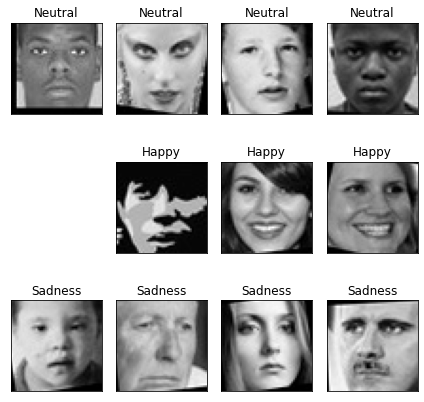

In [40]:
num_emotions = len(TOP_EMOTIONS)
fig = pyplot.figure(1, (num_emotions*2, num_emotions*2))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(num_emotions,4,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [41]:
%%time

print("Extracting facial ROI, this may take some time")

face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor(BASE_PATH+"dumps/shape_predictor_68_face_landmarks.dat")

ROI_1 = list(set(range(17,48)) - set(range(29,36)))
ROI_2 = list(range(48,68)) + [33, 4, 14]
roi1_arr = np.empty(shape=(total_images,25,50,1))
roi2_arr = np.empty(shape=(total_images,25,50,1))

count = 0
idx = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        print(f"processing {dir_} images...")

        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f, 0)
            # img_ = cv2.resize(img, (96,96))
            img_ = img

            faces = face_detector(img_)
            
            if faces:
                for face in faces:
                    ROI1_landmarks = []
                    ROI2_landmarks = []
                    landmarks = shape_predictor(img_, face)
                    for i in range(0, 68):
                        x = landmarks.part(i).x
                        y = landmarks.part(i).y
                        if i in ROI_1:
                            ROI1_landmarks.append((x,y))
                        if i in ROI_2:
                            ROI2_landmarks.append((x,y))

                    (x, y, w, h) = cv2.boundingRect(np.array(ROI1_landmarks))
                    roi1 = img_[y:y + h, x:x + w]
                    roi1 = cv2.resize(roi1, (50,25), interpolation=cv2.INTER_CUBIC)
                    roi1_arr[idx] = np.expand_dims(roi1, axis=2)

                    (x, y, w, h) = cv2.boundingRect(np.array(ROI2_landmarks))
                    roi2 = img_[y:y + h, x:x + w]
                    roi2 = cv2.resize(roi2, (50,25), interpolation=cv2.INTER_CUBIC)
                    roi2_arr[idx] = np.expand_dims(roi2, axis=2)

                    idx += 1
            else:
                count += 1

print(f"\ntotal images with no facial landmarks: {count}")

roi1_arr = np.array(roi1_arr)
print("ROI1", roi1_arr.shape)

roi2_arr = np.array(roi2_arr)
print("ROI2", roi2_arr.shape)

print("\n")

Extracting facial ROI, this may take some time
processing Neutral images...
processing Happy images...
processing Sadness images...

total images with no facial landmarks: 4187
ROI1 (4187, 25, 50, 1)
ROI2 (4187, 25, 50, 1)


CPU times: user 2.69 s, sys: 158 ms, total: 2.85 s
Wall time: 2.85 s


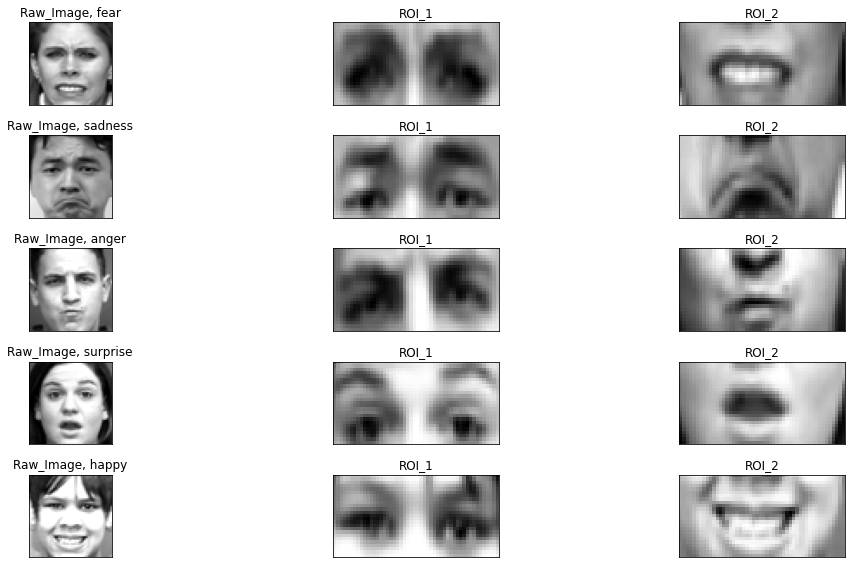

In [0]:
fig = pyplot.figure(1, (18,8))

np.random.seed(10)
idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=1, replace=False)
    sample_images = img_arr[sample_indices]
    sample_roi1 = roi1_arr[sample_indices]
    sample_roi2 = roi2_arr[sample_indices]

    for img,roi1,roi2 in zip(sample_images, sample_roi1, sample_roi2):
        idx += 1
        ax = pyplot.subplot(5,3,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Raw_Image, {label_to_text[k]}")

        idx += 1
        ax = pyplot.subplot(5,3,idx)
        ax.imshow(roi1.reshape(25,50), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("ROI_1")

        idx += 1
        ax = pyplot.subplot(5,3,idx)
        ax.imshow(roi2.reshape(25,50), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("ROI_2")

        pyplot.tight_layout()

In [0]:
hog_features = []
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        print(f"processing {dir_} images...")

        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f, 0)
            img_ = cv2.resize(img, (64,128))
            # img_ = cv2.equalizeHist(img_)

            hog = cv2.HOGDescriptor()
            hog_descr = hog.compute(img_)
            hog_features.append(hog_descr)

hog_features = np.array(hog_features)
print(hog_features.shape)

processing fear images...
processing sadness images...
processing anger images...
processing surprise images...
processing happy images...
(750, 3780, 1)


In [0]:
Xtrain_img, Xtest_img, Xtrain_roi1, Xtest_roi1, Xtrain_roi2, Xtest_roi2, Xtrain_hogfeat, Xtest_hogfeat, y_train, y_test = \
train_test_split(img_arr, roi1_arr, roi2_arr, hog_features, img_label,
                shuffle=True, stratify=img_label, train_size=0.7, random_state=42)

print(Xtrain_img.shape, Xtrain_roi1.shape, Xtrain_roi2.shape, Xtrain_hogfeat.shape, y_train.shape)
print(Xtest_img.shape, Xtest_roi1.shape, Xtest_roi2.shape, Xtest_hogfeat.shape, y_test.shape)

(525, 48, 48, 1) (525, 25, 50, 1) (525, 25, 50, 1) (525, 3780, 1) (525, 5)
(225, 48, 48, 1) (225, 25, 50, 1) (225, 25, 50, 1) (225, 3780, 1) (225, 5)


In [0]:
def full_image_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_DCNN")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1_img'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_img')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2_img'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2_img')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1_img')(batchnorm_2)
    dropout_1 = Dropout(0.4, name='dropout_1_img')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3_img'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3_img')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4_img'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4_img')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2_img')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2_img')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5_img'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5_img')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6_img'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6_img')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3_img')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3_img')(maxpool2d_3)

    flatten = Flatten(name='flatten_dcnn_img')(dropout_3)
        
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_dcnn_img'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7_img')(dense_1)
    
    model_out = Dropout(0.6, name='dropout_4_img')(batchnorm_7)
    
    return model_in, model_out

In [0]:
def roi1_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_ROI1")
    
    conv2d_1 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1_roi1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_roi1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2_roi1'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2_roi1')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1_roi1')(batchnorm_2)
    dropout_1 = Dropout(0.4, name='dropout_1_roi1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3_roi1'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3_roi1')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4_roi1'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4_roi1')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2_roi1')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2_roi1')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5_roi1'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5_roi1')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6_roi1'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6_roi1')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3_roi1')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3_roi1')(maxpool2d_3)

    flatten = Flatten(name='flatten_roi1')(dropout_3)
        
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_roi1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7_roi1')(dense_1)
    
    model_out = Dropout(0.6, name='dropout_4_roi1')(batchnorm_7)
    
    return model_in, model_out

In [0]:
def roi2_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_ROI2")
    
    conv2d_1 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1_roi2'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_roi2')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2_roi2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2_roi2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1_roi2')(batchnorm_2)
    dropout_1 = Dropout(0.4, name='dropout_1_roi2')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3_roi2'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3_roi2')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4_roi2'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4_roi2')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2_roi2')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2_roi2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5_roi2'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5_roi2')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6_roi2'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6_roi2')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3_roi2')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3_roi2')(maxpool2d_3)

    flatten = Flatten(name='flatten_roi2')(dropout_3)
        
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_roi2'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7_roi2')(dense_1)
    
    model_out = Dropout(0.6, name='dropout_4_roi2')(batchnorm_7)
    
    return model_in, model_out

In [0]:
def facial_HOGfeat_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_HOGfeat")
    flatten = Flatten(name="flatten_hogfeat")(model_in)
    dense1 = Dense(256, activation="elu", name="dense1_hogfeat")(flatten)
    model_out = Dropout(0.4, name='dropout1_hogfeat')(dense1)
    return model_in, model_out

In [0]:
def merge_models(models_in: list, models_out: list, num_classes: int, show_summary=False):
    
    concated = Concatenate()(models_out)
    dropout_1 = Dropout(0.3, name='dropout1_merged')(concated)

    dense1 = Dense(128, activation="elu", name="dense1_merged")(dropout_1)
    dropout_2 = Dropout(0.5, name='dropout2_merged')(dense1)

    out = Dense(num_classes, activation="softmax", name="out_layer")(dropout_2)

    model = Model(inputs=models_in, outputs=out, name="Multi_Input_Model")

    if show_summary:
        model.summary()
    
    return model

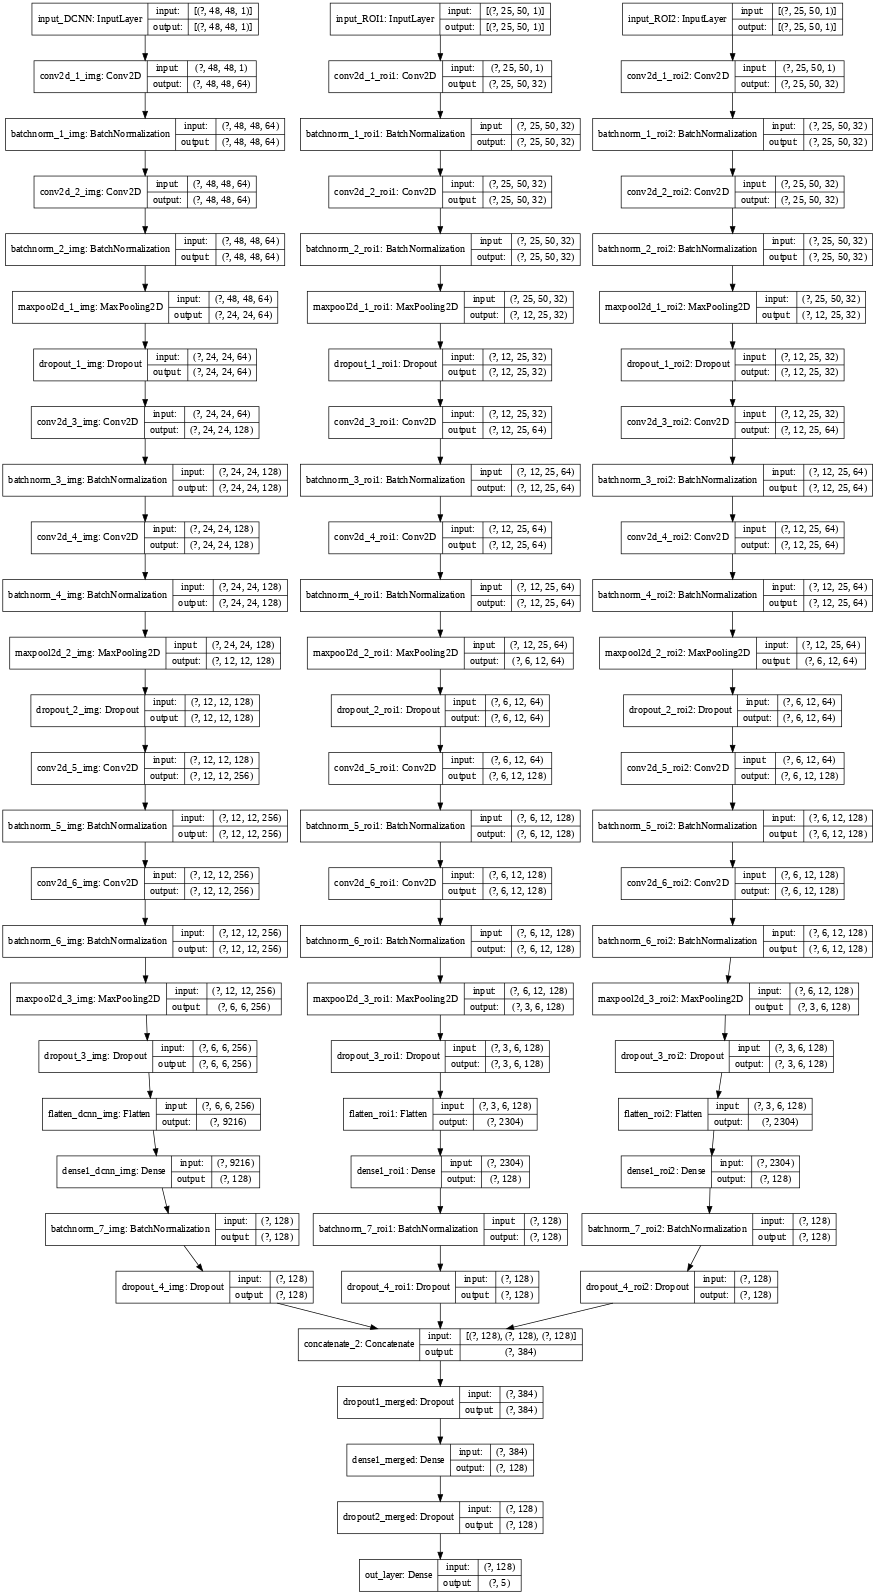

In [0]:
fullimg_in, fullimg_out = full_image_pipeline(input_shape=(48,48,1))
roi1_in, roi1_out = roi1_pipeline(input_shape=(25,50,1))
roi2_in, roi2_out = roi2_pipeline(input_shape=(25,50,1))
hogfeat_in, hogfeat_out = facial_HOGfeat_pipeline(input_shape=(3780,1))

num_classes = y_train.shape[1]

model = merge_models(
    models_in=[fullimg_in, roi1_in, roi2_in, ],
    models_out=[fullimg_out, roi1_out, roi2_out,],
    num_classes=num_classes,
)

model_name = "img+roi"
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True,
           dpi=50, to_file=BASE_PATH+f'/{model_name}_model.png')

In [0]:
def data_generator(Xtrain_img, Xtrain_roi1, Xtrain_roi2, ytrain, batch_size):
    while True:
        idx = np.random.permutation(Xtrain_img.shape[0])

        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True,
        )

        batches_img = datagen.flow(Xtrain_img[idx], ytrain[idx], batch_size=batch_size, shuffle=False, seed=42)
        batches_img = datagen.flow(Xtrain_img[idx], ytrain[idx], batch_size=batch_size, shuffle=False, seed=42)
        batches_img = datagen.flow(Xtrain_img[idx], ytrain[idx], batch_size=batch_size, shuffle=False, seed=42)
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]

            yield [batch[0], Xtrain_hogimg[idx[ idx0:idx1 ]] ], batch[1]

            idx0 = idx1
            if idx1 >= Xtrain_img.shape[0]:
                break

In [0]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.00008,
    factor=0.3,
    patience=5,
    min_lr=1e-6,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [0]:
batch_size = 16 #10
epochs = 24  #60
lr = 0.001
optim = optimizers.Adam(learning_rate=lr)

model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

history = model.fit(
    x=[Xtrain_img, Xtrain_roi1, Xtrain_roi2],
    y=y_train,
    validation_data=([Xtest_img, Xtest_roi1, Xtest_roi2], y_test),
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/24
17/17 [==============================] - 39s 2s/step - loss: 3.1012 - accuracy: 0.3200 - val_loss: 7.6489 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/24
17/17 [==============================] - 39s 2s/step - loss: 1.9023 - accuracy: 0.5162 - val_loss: 3.6573 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 3/24
17/17 [==============================] - 39s 2s/step - loss: 1.3802 - accuracy: 0.6324 - val_loss: 0.9552 - val_accuracy: 0.7067 - lr: 0.0010
Epoch 4/24
17/17 [==============================] - 39s 2s/step - loss: 0.9422 - accuracy: 0.7352 - val_loss: 1.6686 - val_accuracy: 0.7289 - lr: 0.0010
Epoch 5/24
17/17 [==============================] - 39s 2s/step - loss: 0.8422 - accuracy: 0.7695 - val_loss: 0.7671 - val_accuracy: 0.8311 - lr: 0.0010
Epoch 6/24
17/17 [==============================] - 39s 2s/step - loss: 0.8807 - accuracy: 0.7581 - val_loss: 0.5138 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 7/24
17/17 [==============================] - 39s 2s/step - loss: 0.6137 - a

In [0]:
BASE_PATH

'drive/My Drive/FER/Colab/GauravSharma/Multi-Input-Model/'

In [0]:
model.save(BASE_PATH + f"dumps/img_roi1_roi2.h5")

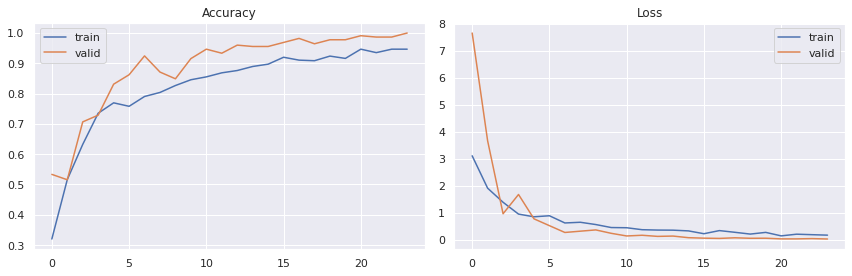

In [0]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig(BASE_PATH + f'epoch_metrics/{model_name}_{num_classes}emo.png')
pyplot.show()

test accuracy: 100.0 %


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        41
           3       1.00      1.00      1.00        75
           4       1.00      1.00      1.00        62

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225



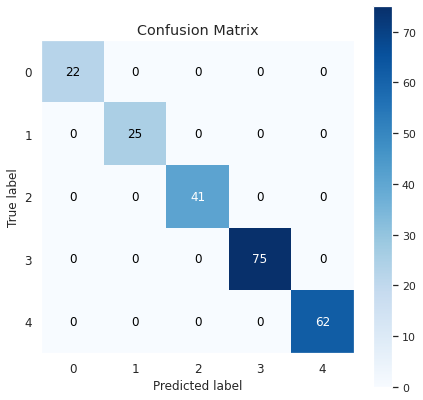

In [0]:
yhat_test = model.predict([Xtest_img, Xtest_roi1, Xtest_roi2])
yhat_test = np.argmax(yhat_test, axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig(BASE_PATH + f'confusion_matrix/{model_name}_{num_classes}emo.png')

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

### Visualizing the Model

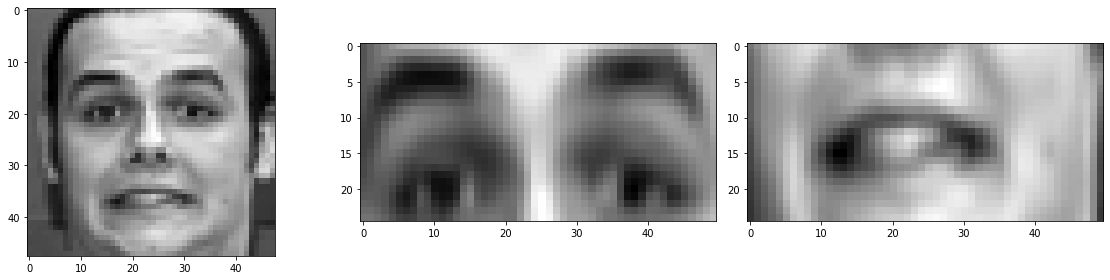

In [0]:
sns.reset_orig()

images = [Xtest_img[0], Xtest_roi1[0], Xtest_roi2[0]]

pyplot.figure(1, (16,4))
for idx,img in enumerate(images):
    ax = pyplot.subplot(1,3,idx+1)
    if idx:
        ax.imshow(img.reshape(25,50), cmap="gray")
    else:
        ax.imshow(img.reshape(48,48), cmap="gray")
    pyplot.tight_layout()

In [0]:
images_ = [np.expand_dims(img, axis=0) for img in images]
images_[0].shape

(1, 48, 48, 1)

In [0]:
layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]
layer_list

[('conv2d_1_img',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fab1bdbf860>),
 ('conv2d_1_roi1',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fab19c44048>),
 ('conv2d_1_roi2',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fab19ac4b38>),
 ('conv2d_2_img',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fab1bdb8ba8>),
 ('conv2d_2_roi1',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fab19bd9438>),
 ('conv2d_2_roi2',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fab19a52fd0>),
 ('conv2d_3_img',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fab19d31b70>),
 ('conv2d_3_roi1',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fab19bb4198>),
 ('conv2d_3_roi2',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fab19a2cc50>),
 ('conv2d_4_img',
  <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7fab19d41e10>),
 ('conv2d_4_roi1',
  <tensorflow.python.keras.layers.c

CPU times: user 15.3 s, sys: 341 ms, total: 15.7 s
Wall time: 15.3 s


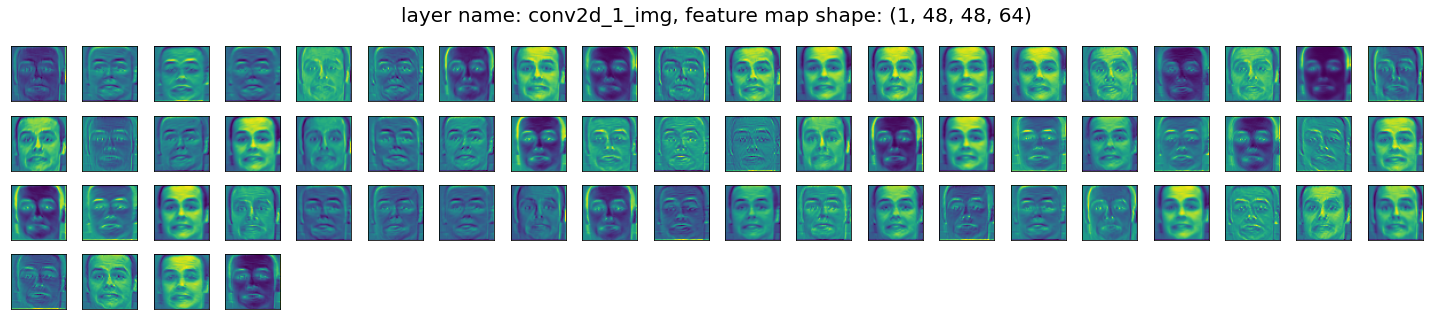

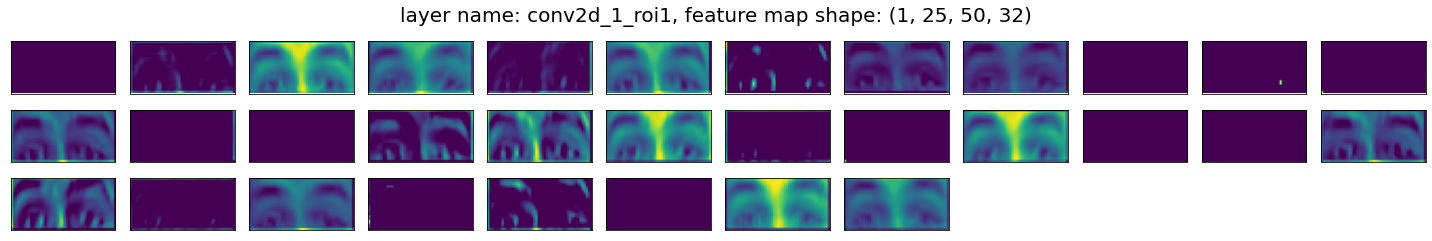

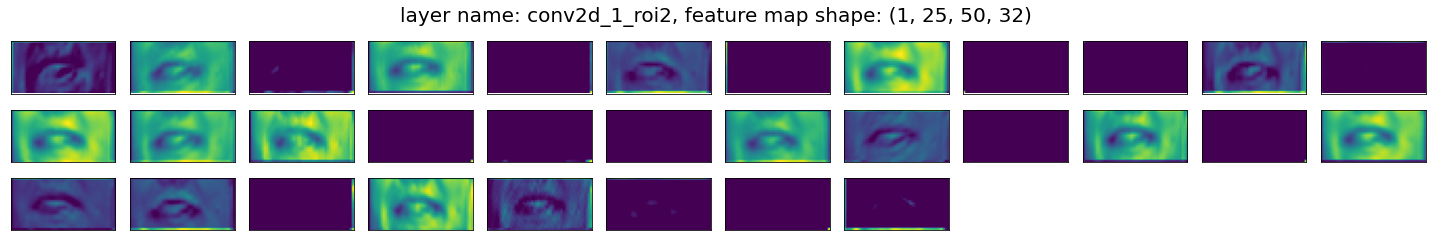

In [0]:
%%time

INTERESTED_CONV_LAYERS = ["conv2d_1_img", "conv2d_1_roi1", "conv2d_1_roi2"]
i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:    
        model_conv2d = Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(images_)

        if "roi" in layer[0]:
            cols = 12
            rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)
        else:
            cols = 20
            rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)

        fig = pyplot.figure(i, (20, rows))
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = pyplot.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="viridis")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, feature map shape: {featuremaps_conv2d.shape}", fontsize=20, y=1.1)
            pyplot.tight_layout()

CPU times: user 55.6 s, sys: 346 ms, total: 55.9 s
Wall time: 55.6 s


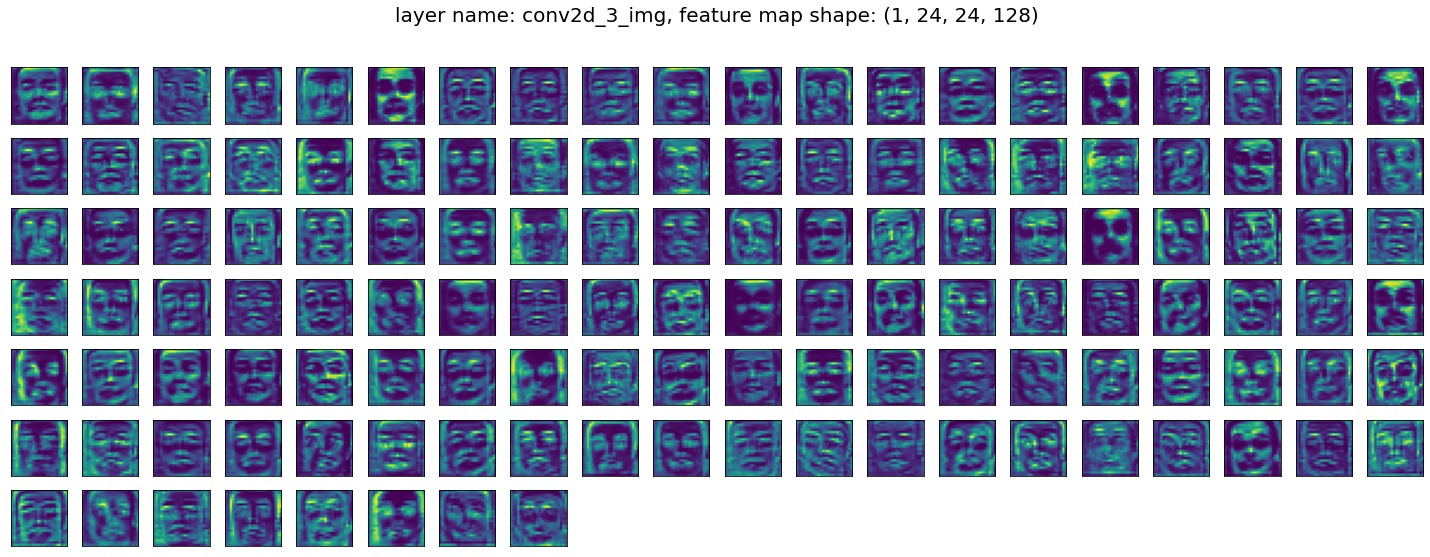

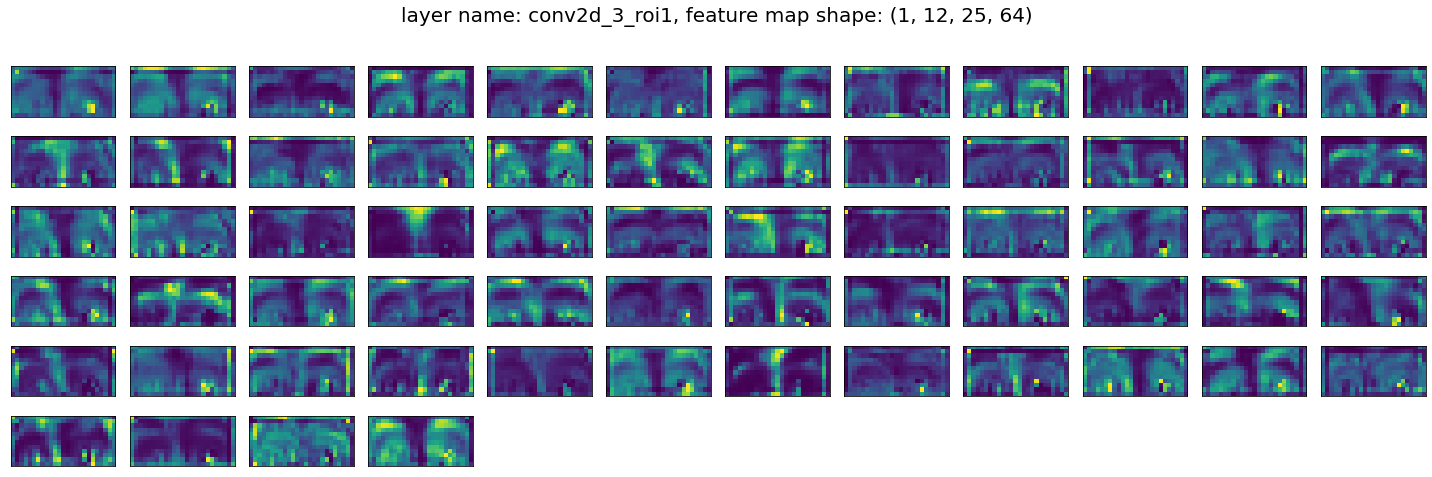

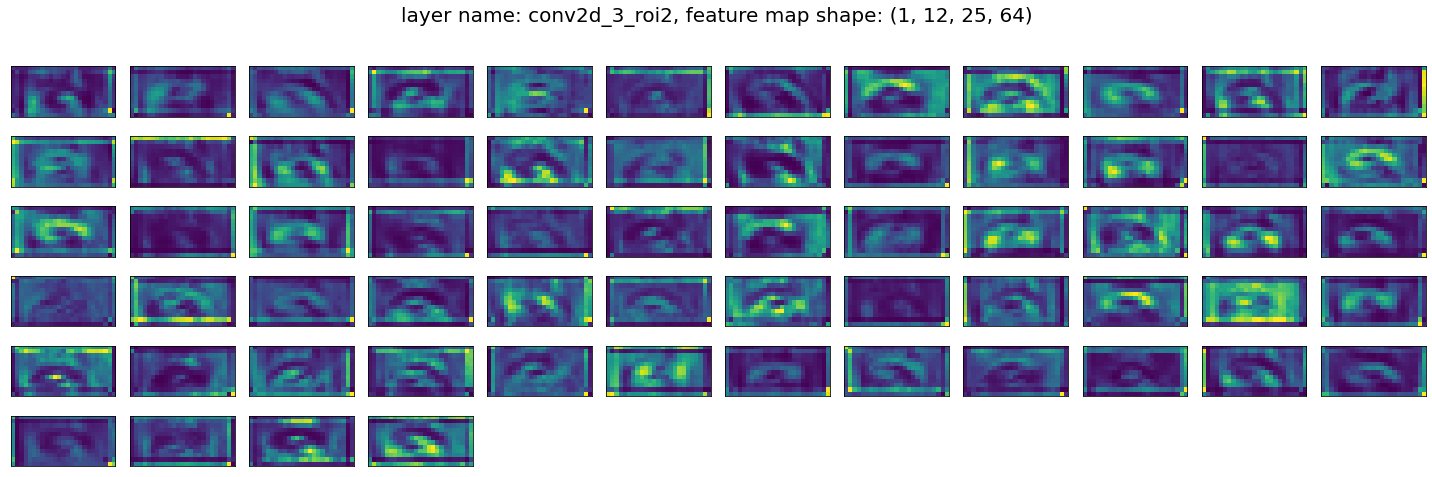

In [0]:
%%time

INTERESTED_CONV_LAYERS = ["conv2d_3_img", "conv2d_3_roi1", "conv2d_3_roi2",]
i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:    
        model_conv2d = Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(images_)
        shape = featuremaps_conv2d.shape

        if "roi" in layer[0]:
            cols = 12
            rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)
        else:
            cols = 20
            rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)

        fig = pyplot.figure(i, (20, rows))
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = pyplot.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="viridis")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, feature map shape: {shape}", fontsize=20, y=1.1)
            pyplot.tight_layout()

CPU times: user 32.8 s, sys: 326 ms, total: 33.1 s
Wall time: 32.8 s


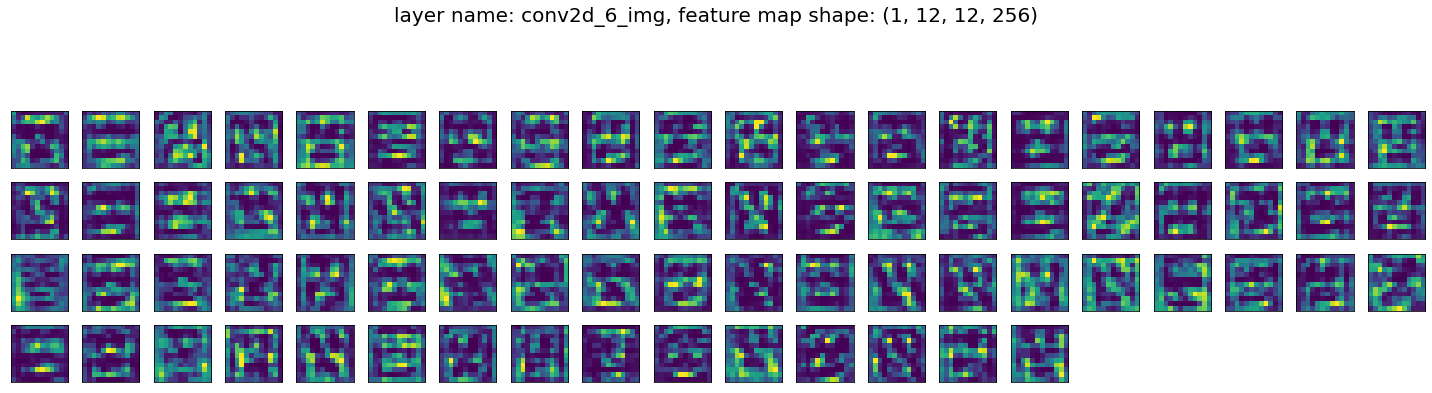

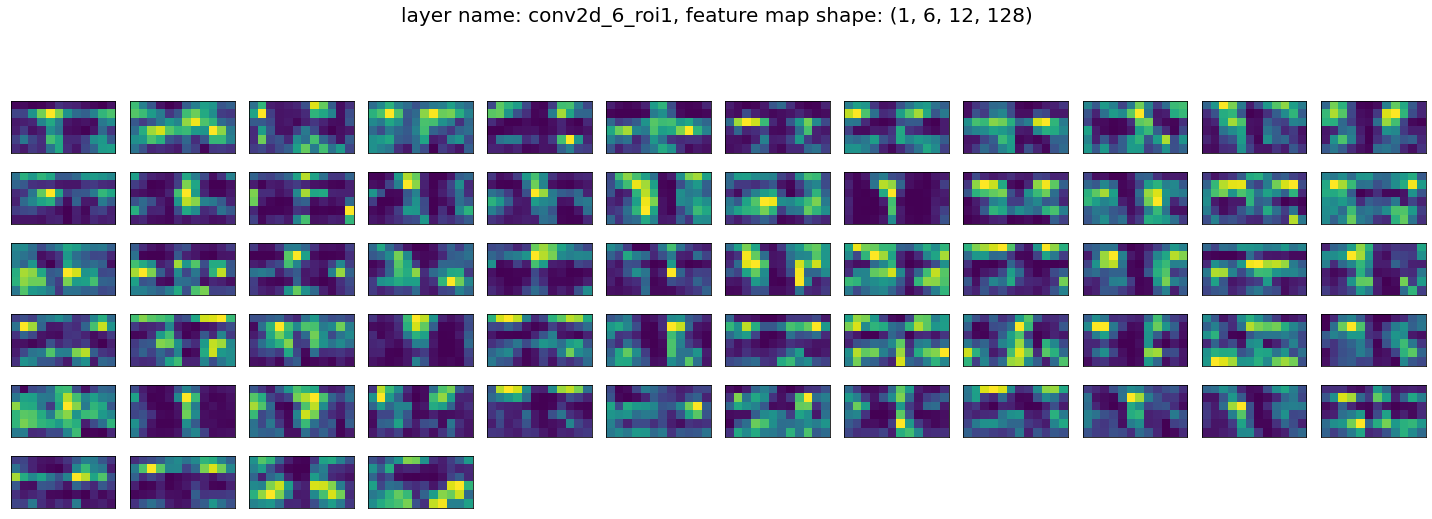

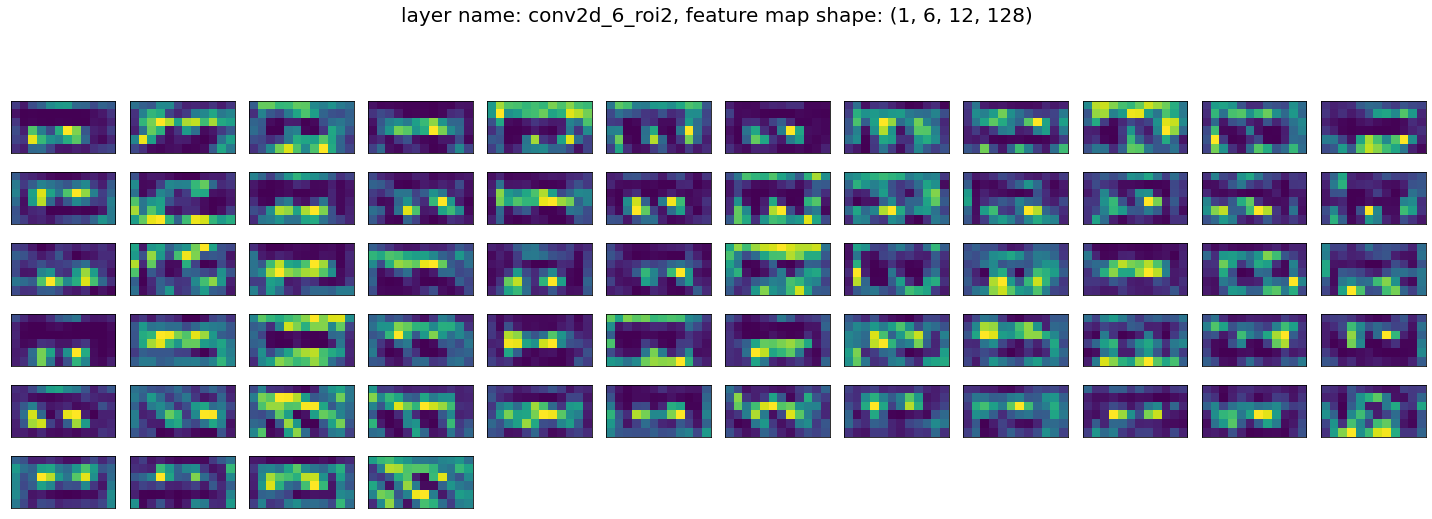

In [0]:
%%time

INTERESTED_CONV_LAYERS = ["conv2d_6_img", "conv2d_6_roi1", "conv2d_6_roi2"]
i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:    
        model_conv2d = Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(images_)
        shape = featuremaps_conv2d.shape

        if "roi" in layer[0]:
            cols = 12
            rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)
            featuremaps_conv2d = featuremaps_conv2d[:,:,:,:64]
        else:
            cols = 20
            rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)
            featuremaps_conv2d = featuremaps_conv2d[:,:,:,:75]

        fig = pyplot.figure(i, (20, rows))
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = pyplot.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="viridis")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, feature map shape: {shape}", fontsize=20, y=1.1)
            pyplot.tight_layout()

#### Let's plot Class Activation Map (CAM) 

In [0]:
preds = model.predict(images_)
label_to_text[np.argmax(preds[0])]

'fear'

In [0]:
pred_vector_output = model.output[:, np.argmax(preds[0])]
pred_vector_output

<tf.Tensor 'strided_slice_17:0' shape=(None,) dtype=float32>

In [0]:
INTERESTED_CONV_LAYERS = ["conv2d_3_img", "conv2d_3_roi1", "conv2d_3_roi2"]



heatmaps = []
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([images_])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, 6, i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()

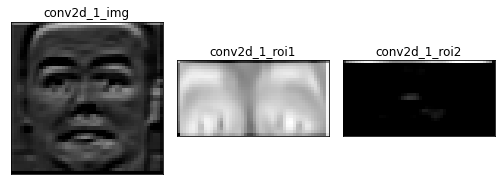

In [0]:
INTERESTED_CONV_LAYERS = ["conv2d_1_img", "conv2d_1_roi1", "conv2d_1_roi2"]

pred_vector_output = model.output[:, np.argmax(preds[0])]

heatmaps = []

for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([images_])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, 6, i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()

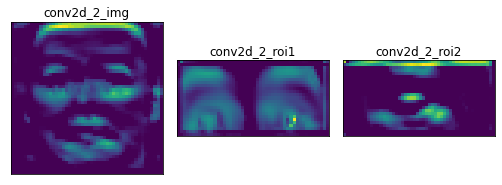

In [0]:
INTERESTED_CONV_LAYERS = ["conv2d_2_img", "conv2d_2_roi1", "conv2d_2_roi2"]

pred_vector_output = model.output[:, np.argmax(preds[0])]

heatmaps = []

for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([images_])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, 6, i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()

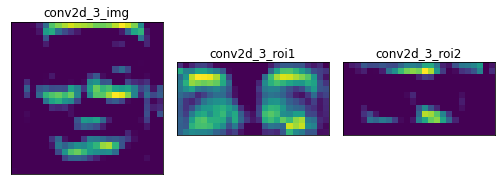

In [0]:
INTERESTED_CONV_LAYERS = ["conv2d_3_img", "conv2d_3_roi1", "conv2d_3_roi2"]

pred_vector_output = model.output[:, np.argmax(preds[0])]

heatmaps = []

for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([images_])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, 6, i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()

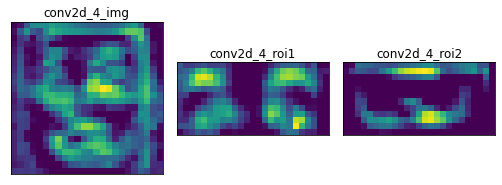

In [0]:
INTERESTED_CONV_LAYERS = ["conv2d_4_img", "conv2d_4_roi1", "conv2d_4_roi2"]

pred_vector_output = model.output[:, np.argmax(preds[0])]

heatmaps = []

for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([images_])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, 6, i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()

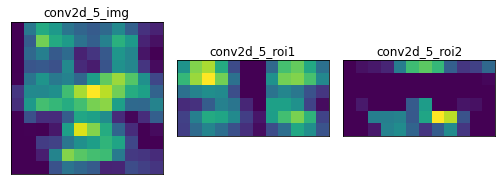

In [0]:
INTERESTED_CONV_LAYERS = ["conv2d_5_img", "conv2d_5_roi1", "conv2d_5_roi2"]

pred_vector_output = model.output[:, np.argmax(preds[0])]

heatmaps = []

for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([images_])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, 6, i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()

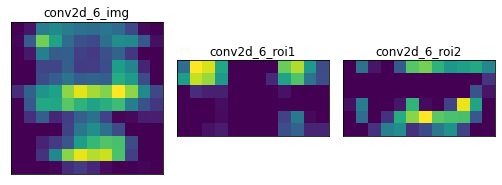

In [0]:
INTERESTED_CONV_LAYERS = ["conv2d_6_img", "conv2d_6_roi1", "conv2d_6_roi2"]

pred_vector_output = model.output[:, np.argmax(preds[0])]

heatmaps = []

for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([images_])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, 6, i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()